<table class="sprawko-header" style="width: 90%; border-style: hidden; font-size: 22px; line-height: 1.2em;">
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">Informatyka, studia dzienne, II st.</td>
    <td style="width: 50%; text-align: right; border-style: hidden;">semestr II</td>
</tr>
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">
        <b>Współczesne technologie programowania</b><br> Prowadzący: Kamil Stokfiszewski
    </td>
    <td style="width: 50%; text-align: right; border-style: hidden;">
        2016/2017<br> wtorek, 10:15
    </td>
</tr>
<tr style="border-style: hidden;">
    <td colspan="2">
        <ul style="width: 100%; text-align: center;  list-style: none;">
            <li>Daniel Pęczek 207585</li>
            <li>Michał Sośnicki 207597</li>
        </ul>
    </td>
</tr>
</table>

# Ćwiczenie 3: Obliczenia ogólnego przeznaczenia na procesorach graficznych z synchronizacją wątków obliczeniowych. 

## Wprowadzenie
Zadanie polegało na stworzeniu programu wykonującego obliczenia z wykorzystaniem procesorów graficznych koniecznością synchronizacji wątków. Było dostępnych kilka wariantów zadania, przy czym wybrany został wariant równoległego sortowania bąbelkowego. Algorytm został zrealizowany także w wersji sekwencyjnej i w sprawozdaniu obie wersje zostały porównane.

## Realizacja

Program wykonujący sortowanie zrealizowano w języku `C++` z wykorzystaniem platformy `CUDA`. Program przyjmuje na wejściu trzy liczby całkowite: rozmiar danych $N$ i zakres danych $min$ i $max$. W pierwszym kroku generowany jest wektor liczb długości $N$ i wypełniane są one losowo wartościami z przedziału $[min, max]$. Następnie jego kilka kopii jest sortowanych. Dokonywane jest to osobno algorytmem sekwencyjnym i masowo-równoległym. Program mierzy czas działania obu części i wypisuje wyniki. Na koniec obie wartości są porównywane i jeżeli algorytmy dały różne wyniki, to wypisywana jest informacja o tym, a program kończy się błędem.

Pomiar czasu odbywa się z wykorzystaniem funkcji `clock_gettimez` z parametrem `CLOCK_PROCESS_CPUTIME_ID` w pierwszym przypadku. W drugim przypadku z GPU wykorzystywana jest funkcja `cudaEventElapsedTime`, mierząca czas między dwoma wywołaniami `cudaEventRecord`.

Analizę czasu wykonywania i wykresy wykonano w środowisku `Jupyter` w języku `Python` z bibliotekami `numpy` oraz `matplotlib`. Skrypty pozyskują wyniki poprzez uruchamianie opisanego wcześniej programu i analizę jego wyjścia. `Jupyter` umożliwia wzbogacenie kodu o dobrze prezentujące się wizualnie bloki `markdown`, więc ta część rozwiązania stanowi zarazem sprawozdanie z zadania.

Testy przeprowadzono na komputerze z kartą graficzną `NVIDIA GeForce GTS 450` (architektura `Fermi`) i procesorem `Intel Core i5-760 2.80 GHz`. Czas jest wyznaczany przez wykonanie programu pięć razy. Z czasów usuwany jest wynik minimalny i maksymalny, a z pozostałych liczona jest średnia. Od rozmiarów siatek bloków oraz liczby wątków na blok oczekuje się, że w każdym z dziesięciu testów dla tych samych danych będą one takie same. Jest to sprawdzane i jeżeli by tak nie było, generowanie sprawozdania zakończyłoby się błędem. 

In [1]:
import functools as fn
import math
import re
import subprocess as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display

In [2]:
def run_get_stdout(name, *args):
    subprocess_args = [name] + list(map(str, args))
    output = sp.run(subprocess_args, stdout=sp.PIPE).stdout
    return output.decode('utf-8')

OUTPUT_REGEX = re.compile(r"CPU time: (\d+\.\d+)s\n"
                          r"Block: (\d+) (\d+) (\d+)\n"
                          r"Thread: (\d+) (\d+) (\d+)\n"
                          r"GPU time: (\d+\.\d+)ms\n")

def parse_bubblesort(output):
    try:
        match = OUTPUT_REGEX.fullmatch(output)
        cpu_time_ms = float(match.group(1)) * 1000
        block_counts = map(int, match.group(2, 3, 4))
        thread_counts = map(int, match.group(5, 6, 7))
        gpu_time_ms = float(match.group(8))
    except AttributeError as e:
        print(output)
        raise e
    return (cpu_time_ms, tuple(block_counts), tuple(thread_counts), gpu_time_ms)

def all_rows_equal(matrix):
    np_matrix = np.array(matrix)
    if np_matrix.size == 0:
        return True
    return np.all(np_matrix == np_matrix[0,:])

def aggregate_bubblesorts(results):
    cpu_times, block_countss, thread_countss, gpu_times = zip(*results)
    mean_cpu_time = np.sort(cpu_times)[1:-1].mean()
    mean_gpu_time = np.sort(gpu_times)[1:-1].mean()
                  
    if not all_rows_equal(block_countss):
        raise ValueError("Block counts not equal")
    block_counts = np.array(block_countss[0])
    
    if not all_rows_equal(thread_countss):
        raise ValueError("Thread counts not equal")
    thread_counts = np.array(thread_countss[0])
                  
    return (mean_cpu_time, mean_gpu_time, block_counts, thread_counts)

def run_bubblesort(repeats, size, a, b):
    outputs = [run_get_stdout('../Zadanie3/main.out', size, a, b) for _ in range(repeats)]
    results = [parse_bubblesort(output) for output in outputs]
    return aggregate_bubblesorts(results)

## Porównanie czasu działania na CPU i GPU

Program uruchomiono dziesięć dla rozmiarów danych będących kolejnymi potęgami dwójki od $2$ do $32768$.
Dane generowane są z przedziału $[10^{-10}, 10^{10}]$. Wyniki zaprezentowano poniżej.

Jak widać wykonywanie obliczeń algorytmem sekwencyjnym jest szybsze aż do rozmiaru $2048$,
gdzie są one bardzo zbliżone i algorytm masowo-równoległy zaczyna mieć przewagę. Dla większych macierzy wykonywanie obliczeń na GPU jest szybsze, przy czym przewaga ta rośnie wraz z rozmiarem danych.

Wynika z tego, iż z wykonywaniem obliczeń na GPU wiąże się pewien stały koszt inicjalizacji, który sprawia, że lepiej
jest dla mniejszych danych wykonać obliczenia na CPU. Pierwszy algorytm, sądząc po wykresach, ma kwadratową złożoność obliczeniową względem rozmiaru wektora. Jest to zgodne z naszą wiedzą o algorytmie `bubblesort`. 

Jeśli chodzi o drugi algorytm, GPU daje możliwość zrównoleglania obliczeń, co wykorzystujemy, jednakże nie ma mniejszej złożoności. Ta wersja algorytmu wymaga wykonania `N` razy podprocedury zamieniającej sąsiednie elementy i między każdym wykonaniem wątki są synchronizowane w ten sposób, iż kernel jest wywołany ponownie. Ta podprocedura teoretycznie przy nieograniczonej liczbie wątków mogłaby wszystkich zamian dokonać jednocześnie i cały algorytm miałby złożoność liniową, jednakże w rzeczywistości nasz procesor ma ograniczone możliwości i jakby rozmiary wektorów stały się dużo większe, to algorytm powinien pokazać podobną złożoność. Jednak dla przetestowanych rozmiarów czas wykonywania rośnie w przybliżeniu liniowo.

In [3]:
def plot_to_data(data_sizes, running_times, xlabel, ylabel, tick_limit, show=True):
    tick_skip = math.ceil(data_sizes.size / tick_limit)
    tick_xs = np.arange(0, data_sizes.size, tick_skip)
    
    ax = plt.subplot(1, 1, 1)
    plt.plot(np.arange(data_sizes.size), running_times, 'o')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    ax.set_xticks(tick_xs)
    ax.set_xticklabels(data_sizes[tick_xs])
    if show:
        plt.show()
    
def plot_times(data_sizes, results, tick_limit=12):
    cpu_times, gpu_times, _, _ = zip(*results)
    plot_to_data(data_sizes, cpu_times, 'Vector size', 'Running times (CPU) [ms]', tick_limit)
    plot_to_data(data_sizes, gpu_times, 'Vector size', 'Running times (GPU) [ms]', tick_limit)
    
def display_ratios(data_sizes, results, tick_limit=12):
    cpu_times, gpu_times, _, _ = zip(*results)
    cpu_ratios = np.hstack([[math.nan], np.array(cpu_times)[1:] / cpu_times[:-1]])
    gpu_ratios = np.hstack([[math.nan], np.array(gpu_times)[1:] / gpu_times[:-1]])
    time_ratios = np.array(cpu_times) / gpu_times
    all_data = np.vstack([data_sizes, cpu_times, cpu_ratios, gpu_times, gpu_ratios, time_ratios]).T
    col_names = ['Data size', 'CPU time [ms]', 'CPU time ratio', 
                 'GPU time [ms]', 'GPU time ratio', 'CPU / GPU time ratio']
    df = pd.DataFrame(all_data, columns=col_names)
    df['Data size'] = df['Data size'].astype(int)
    plot_to_data(data_sizes, time_ratios, 'Vector size', 'CPU / GPU time ratio', tick_limit)
    display(df)
    
data_sizes = np.exp2(np.arange(1, 16)).astype(np.int32)

In [4]:
results_large = [run_bubblesort(5, data_size, 1e-10, 1e10) for data_size in data_sizes]

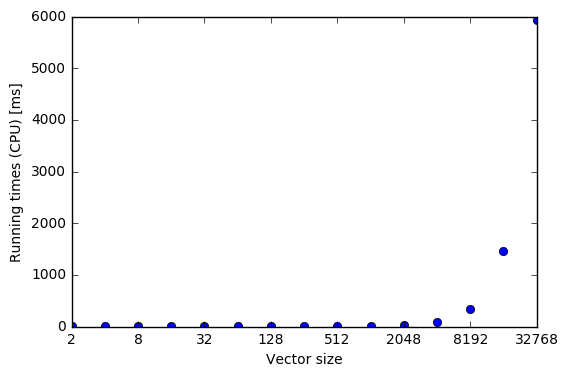

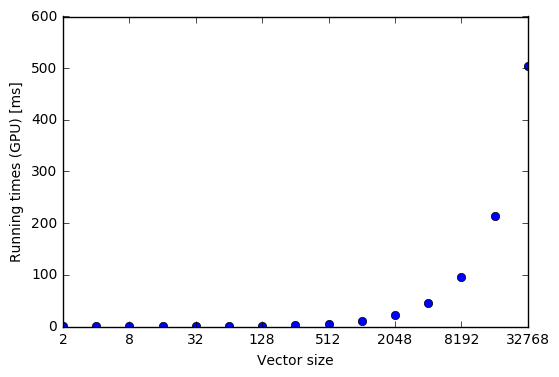

In [5]:
plot_times(data_sizes, results_large)

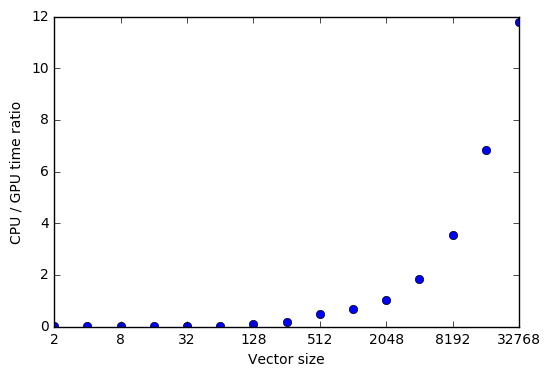

,Data size,CPU time [ms],CPU time ratio,GPU time [ms],GPU time ratio,CPU / GPU time ratio
0,2,0.001015,NaN,0.034187,NaN,0.029690
1,4,0.001173,1.155665,0.053877,1.575975,0.021772
2,8,0.001632,1.391589,0.097344,1.806771,0.016769
3,16,0.003408,2.087605,0.186549,1.916393,0.018267
4,32,0.009474,2.780104,0.349931,1.875808,0.027073
5,64,0.025558,2.697794,0.684768,1.956868,0.037324
6,128,0.132914,5.200498,1.340107,1.957023,0.099182
7,256,0.457883,3.444951,2.690933,2.007999,0.170158
8,512,2.524663,5.513768,5.427040,2.016787,0.465201
9,1024,7.636843,3.024896,11.016533,2.029934,0.693217


In [6]:
display_ratios(data_sizes, results_large)

## Wybór rozmiaru bloku oraz siatki bloków

W programie konieczne było zadecydowanie o liczbie wątków w każdym bloku oraz liczbie bloków w całej siatce bloków. 
Zaprojektowany algorytm wykorzystuje jeden wątek na każdy element macierzy, więc iloczyn liczby bloków i liczby wątków na blok musiał być większy bądź równy rozmiarowi macierzy. Procesor graficzny wykorzystany do testów w architekturze `Fermiego` pozwala na uruchomienie do $1024$ wątków w bloku, przy czym grupowane są one w osnowy o rozmiarze $32$, więc dobrze było, by wybrana liczba wątków na blok była wielokrotnością $32$. 

Wygląda na to, iż w praktyce wartości tych parametrów dobiera się testując algorytm w praktyce. W naszym programie wykorzystaliśmy jednak funkcję dostarczaną przez platformę `Cuda` o nazwie `cudaOccupancyMaxPotentialBlockSize`, która szacuje te wartości. Wykorzystaliśmy je bez dalszych testów. Jak widać program używa jednego bloku aż do użycia $768$ wątków na blok, po czym zwiększa już tylko liczbę bloków.

In [7]:
def display_counts(data_sizes, results):
    _, _, block_counts, thread_counts = zip(*results)
    np_block_counts = np.array(block_counts)[:, :1]
    np_thread_counts = np.array(thread_counts)[:, :1]
    all_data = np.hstack((np_block_counts, np_thread_counts))
    data_frame = pd.DataFrame(all_data, index=data_sizes, columns=['Blocks', 'Threads'])
    display(data_frame)

In [8]:
display_counts(data_sizes, results_large)

,Blocks,Threads
2,1,1
4,1,2
8,1,4
16,1,8
32,1,16
64,1,32
128,1,64
256,1,128
512,1,256
1024,1,512
